# Pre Processing

In [2]:
import numpy as np
import pandas as pd

In [3]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty_level"]

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
data = pd.read_csv("/content/drive/MyDrive/KDD_Data/KDDTrain+.txt",header=None, names=col_names)
data_test = pd.read_csv("/content/drive/MyDrive/KDD_Data/KDDTest+.txt",header=None, names=col_names)

In [7]:
#Validation of data
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,NaN
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,NaN
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,NaN
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,NaN
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,NaN
125969,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,NaN
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,NaN
125971,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.0,1.0,0.0,0.0,0.06,0.05,0.00,255,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,NaN


In [8]:
data.drop(['difficulty_level'],axis=1,inplace=True)
data_test.drop(['difficulty_level'],axis=1,inplace=True)
data.shape

(125973, 42)

In [9]:
data['label'].value_counts()
data_test['label'].value_counts()

normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
xterm                13
rootkit              13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
sqlattack             2
phf                   2
worm                  2
perl                  2
udpstorm              2
loadmodule            2
imap                  1
Name: label, dtype: int64

In [10]:
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
       'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [11]:
change_label(data)
change_label(data_test)

In [12]:
data.label.value_counts()

normal    67343
Dos       45927
Probe     11656
R2L         995
U2R          52
Name: label, dtype: int64

In [13]:
data_test.label.value_counts()

normal    9711
Dos       7460
R2L       2885
Probe     2421
U2R         67
Name: label, dtype: int64

In [14]:
data.label.replace({"normal":0, "Dos":1, "Probe":1, "R2L":1, "U2R":1}, inplace=True)
data_test.label.replace({"normal":0, "Dos":1, "Probe":1, "R2L":1, "U2R":1}, inplace=True)

In [15]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


# Encoding

In [16]:
pip install --upgrade category_encoders

     |████████████████████████████████| 80 kB 4.1 MB/s 


In [17]:
import category_encoders
from category_encoders import LeaveOneOutEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
features = ["protocol_type", "service", "flag"]
targ_enc = LeaveOneOutEncoder(cols=features)
targ_enc.fit(data[features], data['label'])
    
data = data.join(targ_enc.transform(data[features]).add_suffix('_targ'))
data_test = data_test.join(targ_enc.transform(data_test[features]).add_suffix('_targ'))
    
newdata = data.drop(features, axis=1)
newdata_test = data_test.drop(features, axis=1)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [19]:
newdata.shape

(125973, 42)

# Scaling

In [20]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [21]:
numeric_col = newdata.select_dtypes(include='number').columns

In [22]:
rbs_scaler = RobustScaler()
for i in numeric_col:
    arr = newdata[i]
    arr = np.array(arr)
    newdata[i] = rbs_scaler.fit_transform(arr.reshape(len(arr),1))
    arr2 = newdata_test[i]
    arr2 = np.array(arr2)
    newdata_test[i] = rbs_scaler.transform(arr2.reshape(len(arr2),1))

# X Y Dataset 

In [23]:
from tensorflow import keras 

In [24]:
Y_train = newdata.label
X_train = newdata.drop("label",1)
Y_test = newdata_test.label
X_test = newdata_test.drop("label",1)


In [25]:
#Reshaping the train and test dataset
X_train = X_train.values.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.values.reshape(X_test.shape[0],X_test.shape[1],1)

In [26]:
#Validation of the train dataset shape
X_train.shape

(125973, 41, 1)

In [27]:
#Validation of the test dataset shape
Y_train.shape

(125973,)

In [67]:
# finaldata

# LSTM Model

In [28]:
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from tensorflow.keras import Sequential
from keras.layers import Activation, Dense
import matplotlib.pyplot as pyplot

In [29]:
#Creation of the LSTM Model 
model = Sequential()

#Adding an LSTM Layer with the Input Shape of the Train dataset
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=16, return_sequences=True))

#Adding Dense Layer
model.add(Dense(10))
model.add(Activation('relu'))

model.add(Dense(1))

#Adding a sigmod activation layer
model.add(Activation('sigmoid'))

#Compiling the created LSTM Model
model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])


In [30]:
model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])

#Summary of the LSTM Model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 41, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 41, 16)            3136      
_________________________________________________________________
dense (Dense)                (None, 41, 10)            170       
_________________________________________________________________
activation (Activation)      (None, 41, 10)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 41, 1)             11        
_________________________________________________________________
activation_1 (Activation)    (None, 41, 1)             0         
Total params: 7,669
Trainable params: 7,669
Non-trainable params: 0
______________________________________________________

Epoch 1/15
6719/6719 [==============================] - 213s 31ms/step - loss: 0.0907 - accuracy: 0.8894 - val_loss: 0.0643 - val_accuracy: 0.9204
Epoch 2/15
6719/6719 [==============================] - 207s 31ms/step - loss: 0.0531 - accuracy: 0.9322 - val_loss: 0.0550 - val_accuracy: 0.9305
Epoch 3/15
6719/6719 [==============================] - 221s 33ms/step - loss: 0.0473 - accuracy: 0.9381 - val_loss: 0.0495 - val_accuracy: 0.9358
Epoch 4/15
6719/6719 [==============================] - 219s 33ms/step - loss: 0.0403 - accuracy: 0.9445 - val_loss: 0.0418 - val_accuracy: 0.9429
Epoch 5/15
6719/6719 [==============================] - 227s 34ms/step - loss: 0.0380 - accuracy: 0.9478 - val_loss: 0.0385 - val_accuracy: 0.9460
Epoch 6/15
6719/6719 [==============================] - 252s 38ms/step - loss: 0.0363 - accuracy: 0.9499 - val_loss: 0.0353 - val_accuracy: 0.9519
Epoch 7/15
6719/6719 [==============================] - 235s 35ms/step - loss: 0.0351 - accuracy: 0.9516 - val_loss: 0

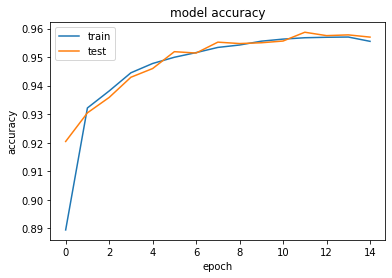

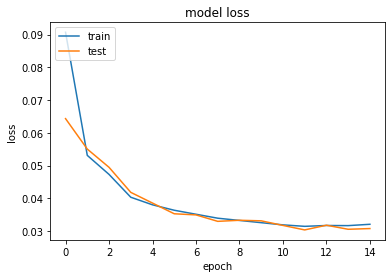

In [31]:
#Fit model for X_train and Y_train
history = model.fit(X_train, Y_train, batch_size = 15, epochs = 15, validation_split=0.2)
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

In [32]:
accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', accuracy[1])

Test accuracy: 0.8193635940551758


In [33]:
#Accuracy of the Model in Test Dataset
accuracy

[0.15785200893878937, 0.8193635940551758]

# Classification

In [34]:
from sklearn.metrics import accuracy_score
# Making predictions on the test dataset
yhat = model.predict(X_test)
yhat_pred=[]
for val in yhat:
    if ((val<0.5).all()):
        yhat_pred.append(0)
    else:
        yhat_pred.append(1)
# Calculate Classification Accuracy
acc = accuracy_score(Y_test, yhat_pred)
print(acc)

0.8878637331440739


# Analysis

In [35]:
from sklearn.metrics import confusion_matrix
#Confusion Matrix on the Test Dataset
confusion_matrix(Y_test, yhat_pred)

array([[ 9058,   653],
       [ 1875, 10958]])

In [36]:
from sklearn.metrics import precision_score, recall_score

#Printing values of Precision and the Recall Score
print(precision_score(Y_test, yhat_pred))
print(recall_score(Y_test, yhat_pred))

0.9437602273705968
0.85389230889114


In [37]:
from sklearn.metrics import f1_score
#Printing values of F1 Score
f1_score(Y_test, yhat_pred)

0.8965799378170513

In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, matthews_corrcoef, \
precision_recall_fscore_support, average_precision_score, \
roc_curve, auc, accuracy_score, precision_recall_curve
import matplotlib.pyplot as pyplot

In [40]:
ns_probs = [0 for _ in range(len(Y_test))]
fpr, tpr, _ = roc_curve(Y_test, yhat_pred)
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, yhat_pred)

In [41]:
# summarize scores ROC AUC
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LSTM: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
LSTM: ROC AUC=0.893


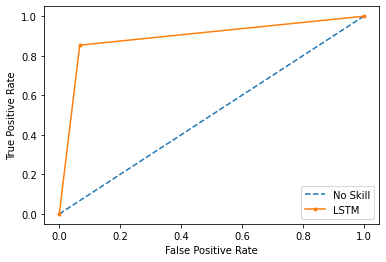

In [42]:
# calculate ROC curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, yhat_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LSTM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

LSTM: f1=0.897 auc=0.940


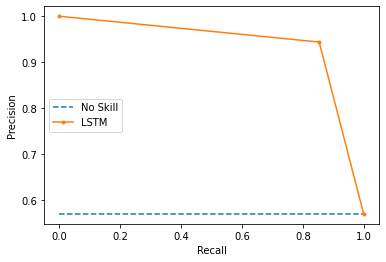

In [43]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# Prediciting Probabilities
lr_probs = model.predict(X_test)

lr_precision, lr_recall, _ = precision_recall_curve(Y_test, yhat_pred)
lr_f1, lr_auc = f1_score(Y_test, yhat_pred), auc(lr_recall, lr_precision)
# summarize scores
print('LSTM: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='LSTM')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()